## Insight worker module for new-issues

### 1.In this notebook I implemented Two ML models on Six repos of different types
### 2.Implemented STL Decompostion on less active repos
### 3.Implemented BiDirectional Stacked LSTM on moderate and highly active repos with different parameteres
### 4.Plotted different graphs like model loss , actual values , prediction values and outliers using scipy interpolate

In [98]:
import pandas as pd
import requests
import datetime
import json
import numpy as np
import seaborn as sns
from numpy import array
from numpy import hstack
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.layers import Dense,TimeDistributed,RepeatVector,Conv1D,MaxPooling1D,Flatten,Activation,Bidirectional
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [2]:
import os
def read_config(section, name=None, environment_variable=None, default=None, config_file_path='../../augur.config.json', no_config_file=0, use_main_config=0):
    """
    Read a variable in specified section of the config file, unless provided an environment variable

    :param section: location of given variable
    :param name: name of variable
    """
    _config_file_name = 'augur.config.json'
    _config_bad = False
    _already_exported = {}
    _runtime_location = 'runtime/'
    _default_config = {}
    _config_file = None

    try:
        _config_file = open(config_file_path, 'r+')
    except:
        print('Couldn\'t open {}'.format(_config_file_name))

    # Load the config file
    try:
        config_text = _config_file.read()
        _config = json.loads(config_text)
    except json.decoder.JSONDecodeError as e:
        if not _config_bad:
            _using_config_file = False
            print('{} could not be parsed, using defaults. Fix that file, or delete it and run this again to regenerate it. Error: {}'.format(config_file_path, str(e)))
        _config = _default_config

    value = None
    if environment_variable is not None:
        value = os.getenv(environment_variable)
    if value is None:
        try:
            if name is not None:
                value = _config[section][name]
            else:
                value = _config[section]
        except Exception as e:
            value = default
            if not section in _config:
                _config[section] = {}

    return value

In [16]:
augur_api_host = read_config("Server", "host", "AUGUR_HOST", "0.0.0.0",config_file_path='/Users/pratikmishra/augur/augur.config.json')
augur_api_port = read_config("Server", "port", "AUGUR_PORT", 5000,config_file_path='/Users/pratikmishra/augur/augur.config.json')

time_series = ['issues-new']
              
def time_series_metrics(repo_id):
    training_days = 365
    
    base_url = 'http://{}:{}/api/unstable/repo-groups/20/repos/{}/'.format(augur_api_host,augur_api_port,repo_id)
    begin_date = datetime.datetime(2019, 3, 31, 0, 0)#datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - datetime.timedelta(days=training_days)
    index = pd.date_range(begin_date, periods=training_days, freq='D')
    df = pd.DataFrame(index)
    df.columns = ['date']
    df['date'] = df['date'].astype(str)

    for endpoint in time_series:
        #print(endpoint)
        
        url = base_url + endpoint
        print("Hitting endpoint: " + url + "\n")
        try:
            data = requests.get(url=url).json()
            #print(data)
        except:
            data = json.loads(json.dumps(requests.get(url=url).text))

        if len(data) == 0:
            print("Endpoint with url: {} returned an empty response. Moving on to next endpoint.\n".format(url))
            continue
                    
        if 'date' not in data[0]:
            print("Endpoint {} is not a timeseries, moving to next endpoint.\n".format(endpoint))
            continue
                
        metric_df = pd.DataFrame.from_records(data)
        metric_df['date'] = pd.to_datetime(metric_df['date']).dt.date
        metric_df['date'] = metric_df['date'].astype(str)
        extra=['repo','rg','week','year']
        for column in metric_df.columns:
            if any(x in column for x in extra):
                metric_df.drop(column,axis=1,inplace=True)
                
        df = pd.DataFrame(pd.merge(df,metric_df.loc[:,metric_df.columns],how = 'left',on = 'date'))
        metric_df.drop('date',axis=1,inplace=True)
        df.rename(columns={i :"{} _ {}".format(endpoint, i) for i in metric_df.columns }, inplace=True)
    return df

In [4]:
repos = pd.read_csv("repo_new-issues_cluster.csv")

In [5]:
repos.head()

,new-issues,cluster,repo_id
0,0.0,0,28055
1,2.0,0,27912
2,250.0,0,25764
3,0.0,0,27314
4,0.0,0,27376


In [6]:
repos['cluster'].value_counts()

0    1172
1       2
2       1
Name: cluster, dtype: int64

### Preprocessing method and LSTM model

In [7]:
#data : dataframe
#tr_days : number of training days
#lback_days : number of days to lookback for next prediction
#n_features : number of features of columns in dataframe for training
#n_predays : next number of days to predict

from keras import optimizers
def preprocess_data(data,tr_days,lback_days,n_features,n_predays):
    
    train_data = data.values

    features_set = []
    labels = []
    for i in range(lback_days, tr_days+1):
        features_set.append(train_data[i-lback_days:i,0])
        labels.append(train_data[i:i+n_predays, 0])

    features_set = np.array(features_set)
    labels = np.array(labels)

    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], n_features))

    
    return features_set,labels


def model_lstm(fetures_set,n_predays,n_features):
    model = Sequential()
    model.add(Bidirectional(LSTM(90, activation='linear',return_sequences=True, input_shape=(features_set.shape[1], n_features))))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(90, activation='linear',return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(90, activation='linear')))
    model.add(Dense(1))
    model.add(Activation('linear'))
    opt = optimizers.Adam(lr=0.0005)
    model.compile(optimizer='adam', loss='mae')
    return model

In [66]:
Selected few repos randomnly from each clusters
import random
filt_2 = repos['cluster'] == 2
filt_1 = repos['cluster'] == 1
filt_0 = repos['cluster'] == 0
repo_highly_active = random.sample(list(repos[filt_2]['repo_id']), 1)
repo_less_active = random.sample(list(repos[filt_0]['repo_id']), 3)
repo_moderate_active = random.sample(list(repos[filt_1]['repo_id']), 2)

In [67]:
repo_less_active

[25806, 25851, 26853]

In [68]:
repo_highly_active

[28150]

In [69]:
repo_moderate_active

[28051, 25726]

### Less Active repos

In [70]:
from functools import reduce
dfs = []
for i in repo_less_active:
    df = time_series_metrics(i)
    df = df.fillna(0)
    df.columns = ['date','{}'.format(i)]
    

    dfs.append(df)
df_less_active = reduce(lambda x, y: pd.merge(x, y, on = 'date'), dfs)   


Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25806/issues-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25851/issues-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/26853/issues-new



In [71]:
df_less_active.head()

,date,25806,25851,26853
0,2019-03-31,0.0,0.0,0.0
1,2019-04-01,0.0,0.0,0.0
2,2019-04-02,0.0,0.0,0.0
3,2019-04-03,0.0,0.0,0.0
4,2019-04-04,0.0,0.0,0.0


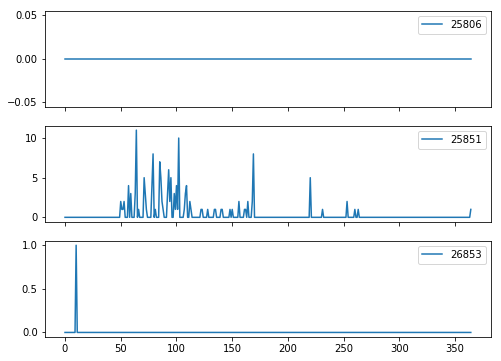

In [72]:
fig,ax = plt.subplots(3,1,figsize=(8,6),sharex=True)

ax[0].plot(df_less_active.iloc[:,1])
ax[1].plot(df_less_active.iloc[:,2])
ax[2].plot(df_less_active.iloc[:,3])


ax[0].legend()
ax[1].legend()
ax[2].legend()

### Implementation of STL Decompostion model 

In [73]:
from statsmodels.tsa.seasonal import STL
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == 'resid':
            ax.plot(series, marker='o', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(legend, frameon=False)



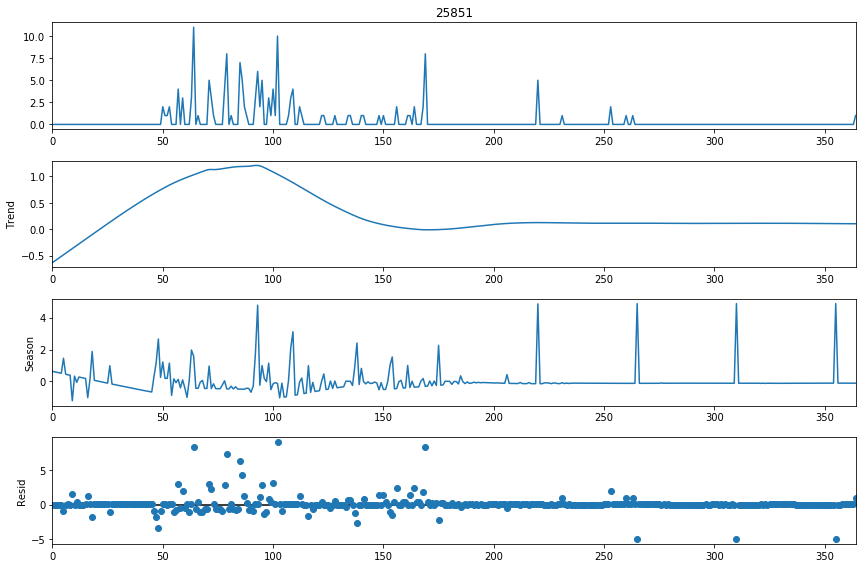

In [74]:
plt.rc('figure',figsize=(12,8))
stl = STL(df_less_active.iloc[:,2], seasonal=5,trend=47,period=45,robust=True)
res = stl.fit()
fig = res.plot()

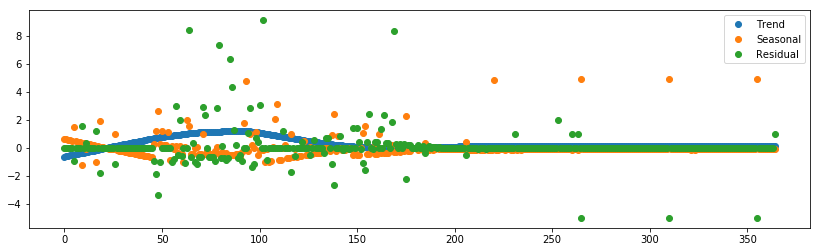

In [75]:
plt.figure(figsize=(14,4))
plt.plot(res.trend , 'o',label='Trend')
plt.plot(res.seasonal , 'o',label='Seasonal')
plt.plot(res.resid , 'o',label='Residual')
plt.legend()

In [76]:
std_resid = np.std(res.resid)
mean_resid = np.mean(res.resid)
print(std_resid)

1.2365199575909085


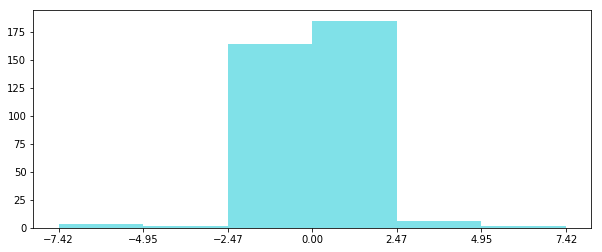

In [77]:
plt.figure(figsize=(10,4))
s=std_resid
bis = [-6*s,-4*s,-2*s,0,2*s,4*s,6*s,]
plt.hist(res.resid,bins=bis,color = '#80e1e8')
plt.xticks(bis)
plt.show()

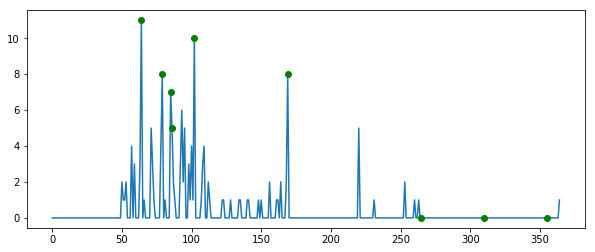

In [79]:
plt.figure(figsize=(10,4))
filt = (res.resid > 3*s) | (res.resid < -3*s)
plt.plot(df_less_active.iloc[:,2])
plt.plot(df_less_active[filt]['25851'],'o',color='g')

In [81]:
anomaly = df_less_active[filt]['25851']
anomaly

64     11.0
79      8.0
85      7.0
86      5.0
102    10.0
169     8.0
265     0.0
310     0.0
355     0.0
Name: 25851, dtype: float64

### Moderately Active repos

In [82]:
dfs = []
for i in repo_moderate_active:
    df = time_series_metrics(i)
    df = df.fillna(0)
    df.columns = ['date','{}'.format(i)]
    

    dfs.append(df)
df_moderate_active = reduce(lambda x, y: pd.merge(x, y, on = 'date'), dfs)   

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/28051/issues-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25726/issues-new



In [83]:
df_moderate_active.head()

,date,28051,25726
0,2019-03-31,8.0,5.0
1,2019-04-01,4.0,3.0
2,2019-04-02,6.0,2.0
3,2019-04-03,4.0,1.0
4,2019-04-04,4.0,5.0


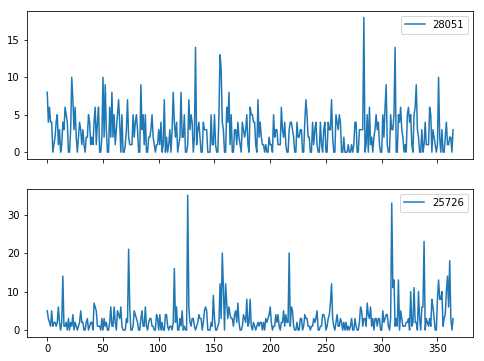

In [85]:
fig,ax = plt.subplots(2,1,figsize=(8,6),sharex=True)

ax[0].plot(df_moderate_active.iloc[:,1])
ax[1].plot(df_moderate_active.iloc[:,2])


ax[0].legend()
ax[1].legend()


In [86]:
from scipy.interpolate import make_interp_spline

### Implementation of LSTM model with look back days=14 and batch size=10

### Model fits on all three repos quite well
### Error = actual values - predicted values
### Points with error more than 2.5 standard devitation will be considered  outliers

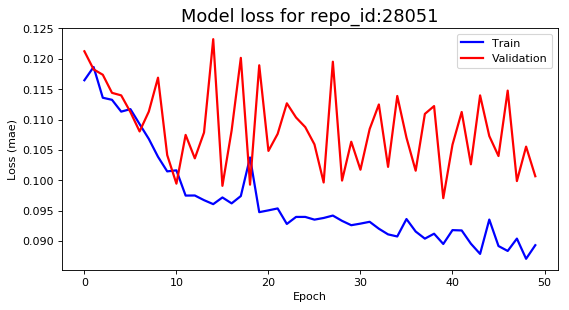

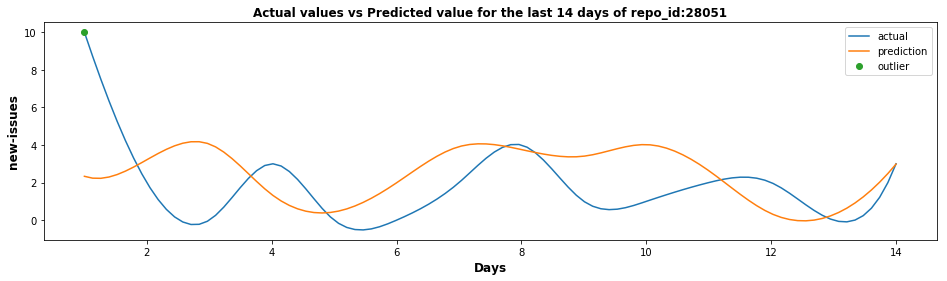

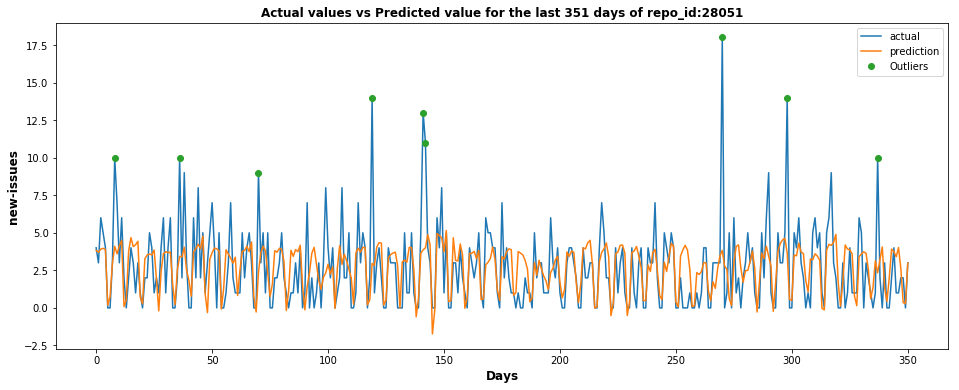

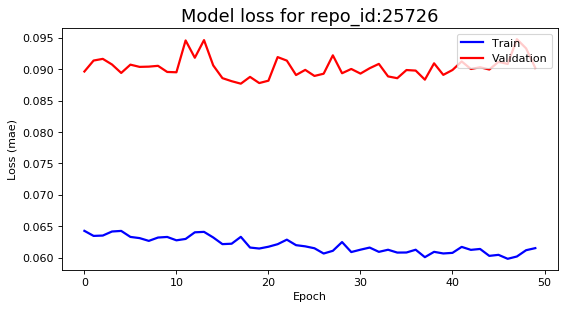

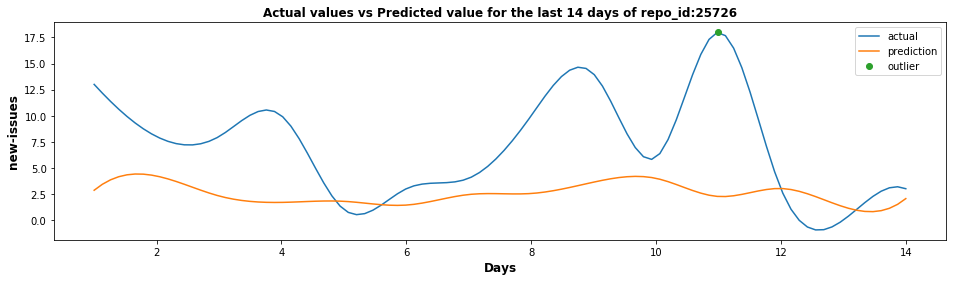

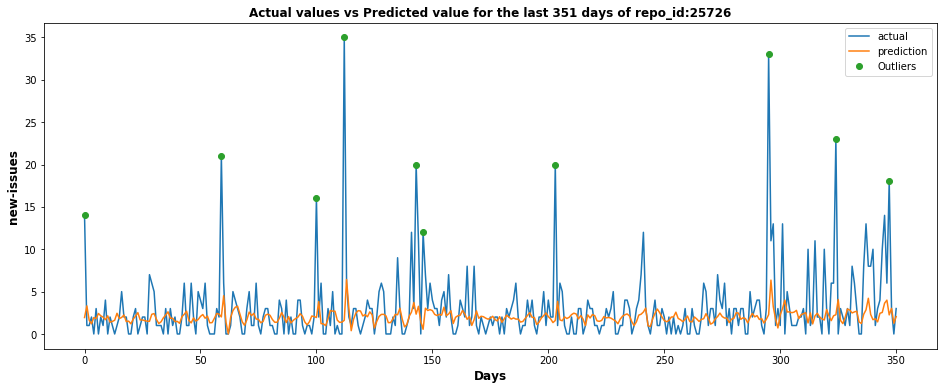

In [90]:
for k in range(1,3):
    
    ### Fiting model
    scaler = MinMaxScaler(feature_range=(0,1))

    data = pd.DataFrame(df_moderate_active.iloc[:,k])
    data = pd.DataFrame(scaler.fit_transform(data.values))

    tr_days = 351
    lback_days = 14
    n_features = 1
    n_predays = 1

    features_set,labels = preprocess_data(data,tr_days,lback_days,n_features,n_predays)
    model = model_lstm(features_set,n_predays,n_features)

    history = model.fit(features_set, labels, epochs = 50, batch_size = 10,validation_split=0.1,verbose=0).history
    
    ### PLot for Model Loss
    fig, ax = plt.subplots(figsize=(8, 4), dpi=80)
    ax.plot(history['loss'], 'b', label='Train', linewidth=2)
    ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('Model loss for repo_id:{}'.format(repo_moderate_active[k-1]), fontsize=16)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    plt.show()
    
    ### Predicting values
    test_inputs = data[ :len(df_moderate_active.iloc[:,k])].values
    test_inputs = test_inputs.reshape(-1,n_features)
    test_features = []
    for i in range(lback_days, len(df_moderate_active.iloc[:,k])):
        test_features.append(test_inputs[i-lback_days:i, 0])

    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], n_features))
    predictions = model.predict(test_features)
    predictions = scaler.inverse_transform(predictions)
    
    
    #Finding anomalies
    test_data = df_moderate_active.iloc[14:,k]
    error = np.array(test_data[:]- predictions[:,0])
    std_error = np.std(error)
    mean_error = np.mean(error)
    
    filt = ( error > 2.5*std_error) | ( error < - 2.5*std_error) 
    anomaly = test_data[filt]
    
    ### plot for actual,predicted values and outliers over last 14 days using scipy interpolate
    
    plt.figure(figsize=(16,4))
    x = x = np.arange(1,15)
    p = df_moderate_active.iloc[351:,k].values
    q = predictions[337:]
    x_new = np.linspace(1, 14, 100)

    p_BSpline = make_interp_spline(x, p)
    p_new = p_BSpline(x_new)

    q_BSpline = make_interp_spline(x, q)
    q_new = q_BSpline(x_new)

    outlier_plot = test_data[337:][filt[337:]]
    outlier_plot.index -= 350
    plt.plot(x_new, p_new,label='actual')
    plt.plot(x_new, q_new,label='prediction')
    plt.plot(outlier_plot,'o',label='outlier')
    plt.title('Actual values vs Predicted value for the last 14 days of repo_id:{}'.format(repo_moderate_active[k-1]),
                     fontweight='bold', fontsize=12)
    plt.xlabel('Days',fontweight='bold', fontsize=12)
    plt.ylabel('new-issues',fontweight='bold', fontsize=12)
    plt.legend()
    plt.show()
    
    ### plot for actual,predicted values and outliers over last 351 days
    
    plt.figure(figsize=(16,6))
    test_data = df_moderate_active.iloc[14:,k]
    outlier_plot = test_data[:][filt[:]]
    outlier_plot.index -= 14
    plt.plot(test_data[:].values,label='actual')
    plt.plot(predictions[:],label='prediction')
    plt.plot(outlier_plot,'o',label='Outliers')

    plt.title('Actual values vs Predicted value for the last 351 days of repo_id:{}'.format(repo_moderate_active[k-1]),
                     fontweight='bold', fontsize=12)
    plt.xlabel('Days',fontweight='bold', fontsize=12)
    plt.ylabel('new-issues',fontweight='bold', fontsize=12)
    plt.legend()
    plt.show()



### Highly Active repos

In [91]:
dfs = []
for i in repo_highly_active:
    df = time_series_metrics(i)
    df = df.fillna(0)
    df.columns = ['date','{}'.format(i)]
    

    dfs.append(df)
df_highly_active = reduce(lambda x, y: pd.merge(x, y, on = 'date'), dfs)

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/28150/issues-new



In [93]:
df_highly_active.head()

,date,28150
0,2019-03-31,4.0
1,2019-04-01,5.0
2,2019-04-02,5.0
3,2019-04-03,3.0
4,2019-04-04,3.0


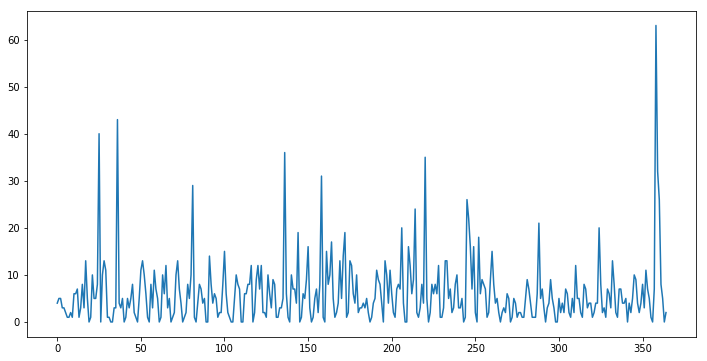

In [96]:
plt.figure(figsize=(12,6))
plt.plot(df_highly_active.iloc[:,1])

### Implementation of LSTM model with look back days=30 and batch size=30
​
### Model fits on  repos quite well
### Error = actual values - predicted values
### Points with error more than 2 standard devitation will be considered  outliers

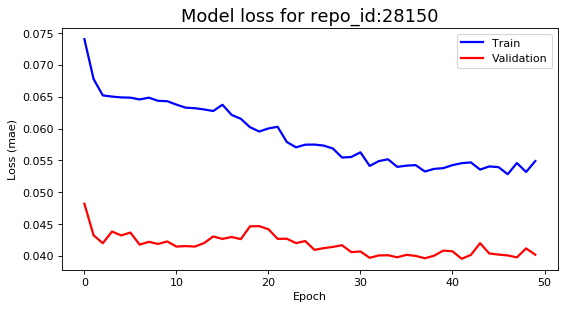

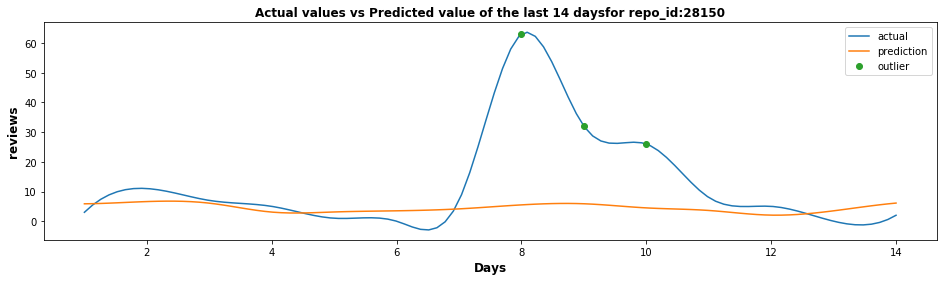

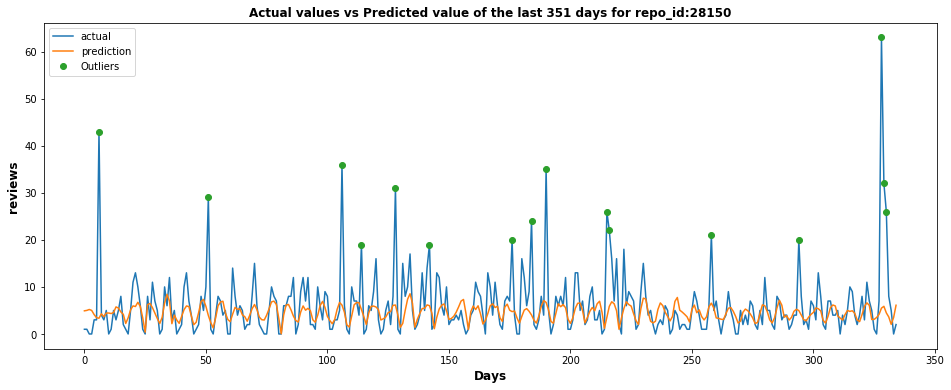

In [97]:
for k in range(1,2):
    
    ### Fiting the model
    scaler = MinMaxScaler(feature_range=(0,1))

    data = pd.DataFrame(df_highly_active.iloc[:,k])
    data = pd.DataFrame(scaler.fit_transform(data.values))

    tr_days = 351
    lback_days = 30
    n_features = 1
    n_predays = 1

    features_set,labels = preprocess_data(data,tr_days,lback_days,n_features,n_predays)
    model = model_lstm(features_set,n_predays,n_features)

    history = model.fit(features_set, labels, epochs = 50, batch_size = 30,validation_split=0.1,verbose=0).history
    
    
    ### Plot for Model Loss
    fig, ax = plt.subplots(figsize=(8, 4), dpi=80)
    ax.plot(history['loss'], 'b', label='Train', linewidth=2)
    ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('Model loss for repo_id:{}'.format(repo_highly_active[k-1]), fontsize=16)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    plt.show()
    
    
    ### Predicting values
    test_inputs = data[ :len(df_highly_active.iloc[:,k])].values
    test_inputs = test_inputs.reshape(-1,n_features)
    test_features = []
    for i in range(lback_days, len(df_highly_active.iloc[:,k])):
        test_features.append(test_inputs[i-lback_days:i, 0])

    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], n_features))
    predictions = model.predict(test_features)
    predictions = scaler.inverse_transform(predictions)
    
    
    #Finding anomalies
    test_data = df_highly_active.iloc[30:,k]
    error = np.array(test_data[:]- predictions[:,0])
    std_error = np.std(error)
    mean_error = np.mean(error)
    
    filt = ( error > 2*std_error) | ( error < - 2*std_error) 
    anomaly = test_data[filt]
    
    ### plot for actual,predicted values and outliers over last 14 days using scipy interpolate
    
    plt.figure(figsize=(16,4))
    x = x = np.arange(1,15)
    p = df_highly_active.iloc[351:,k].values
    q = predictions[321:]
    x_new = np.linspace(1, 14, 100)

    p_BSpline = make_interp_spline(x, p)
    p_new = p_BSpline(x_new)

    q_BSpline = make_interp_spline(x, q)
    q_new = q_BSpline(x_new)

    outlier_plot = test_data[321:][filt[321:]]
    outlier_plot.index -= 350
    plt.plot(x_new, p_new,label='actual')
    plt.plot(x_new, q_new,label='prediction')
    plt.plot(outlier_plot,'o',label='outlier')
    plt.title('Actual values vs Predicted value of the last 14 daysfor repo_id:{}'.format(repo_highly_active[k-1]),
                     fontweight='bold', fontsize=12)
    plt.xlabel('Days',fontweight='bold', fontsize=12)
    plt.ylabel('reviews',fontweight='bold', fontsize=12)
    plt.legend()
    plt.show()
    
    ## plot for actual,predicted values and outliers over last 330 days
    
    plt.figure(figsize=(16,6))
    test_data = df_highly_active.iloc[30:,k]
    outlier_plot = test_data[:][filt[:]]
    outlier_plot.index -= 30
    plt.plot(test_data[:].values,label='actual')
    plt.plot(predictions[:],label='prediction')
    plt.plot(outlier_plot,'o',label='Outliers')

    plt.title('Actual values vs Predicted value of the last 351 days for repo_id:{}'.format(repo_highly_active[k-1]),
                     fontweight='bold', fontsize=12)
    plt.xlabel('Days',fontweight='bold', fontsize=12)
    plt.ylabel('reviews',fontweight='bold', fontsize=12)
    plt.legend()
    plt.show()

